<a href="https://colab.research.google.com/github/PetrovES570/PDA_SOL/blob/main/1_%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%D0%A0%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%D1%81_%D0%B1%D0%BE%D0%BB%D1%8C%D1%88%D0%B8%D0%BC%D0%B8_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%BC%D0%B8_%D0%B2_DASK_%D0%9F%D0%B5%D1%82%D1%80%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практическая работа 1.1. Анализ больших данных с помощью DASK


**Задание.**

`1.1.1.` Настроить среду и рабочий каталог.

`1.1.2.` Загрузить данные.

`1.1.3.` Проверить качество данных (например, отсутствующие значения и выбросы).

`1.1.4.` Удалить столбцы (множество пропусков в значениях, бесполезные столбцы для анализа).

`1.1.1.` **Настроить среду и рабочий каталог.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ls

drive/  sample_data/


In [3]:
!pip install "dask[complete]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.3 MB/s eta 0:00:00


In [4]:
# import libraries
import sys
import os

## import dask libraries
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

# import libraries
import pandas as pd

In [5]:
cwd = os.getcwd()

# print
print('', sys.executable)
print('', cwd)

 /usr/bin/python3
 /content


`1.1.2.` **Загрузить данные.**

In [8]:
df = dd.read_csv('/content/drive/MyDrive/2023_04.csv', dtype={'31': 'object', 'Unnamed: 8': 'object'})
sampled_df = df.sample(frac=0.35) # Get 35% of the data
len(sampled_df)
sampled_df

,Transaction_unique_identifier,price,Date_of_Transfer,postcode,Property_Type,Old/New,Duration,PAON,SAON,Street,Locality,Town/City,District,County,PPDCategory_Type,Record_Status - monthly_file_only
npartitions=3,,,,,,,,,,,,,,,,
,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


`1.1.3.` **Проверить качество данных (например, отсутствующие значения и выбросы).**

In [9]:
# count missing values
missing_values = df.isnull().sum()
missing_values

Dask Series Structure:
npartitions=1
 County     int64
postcode      ...
dtype: int64
Dask Name: dataframe-sum-agg, 4 graph layers

In [10]:
# calculate percent missing values
mysize = df.index.size
missing_count = ((missing_values / mysize) * 100)
missing_count

Dask Series Structure:
npartitions=1
 County     float64
postcode        ...
dtype: float64
Dask Name: mul, 9 graph layers

In [11]:
# запуск вычисления, используя метод подсчета
with ProgressBar():
  missing_count_percent = missing_count.compute()
missing_count_percent

[########################################] | 100% Completed | 3.50 s


Transaction_unique_identifier          0.0
 price                               100.0
 Date_of_Transfer                    100.0
postcode                             100.0
 Property_Type                       100.0
 Old/New                             100.0
Duration                             100.0
 PAON                                100.0
 SAON                                100.0
 Street                              100.0
 Locality                            100.0
 Town/City                           100.0
 District                            100.0
 County                              100.0
 PPDCategory_Type                    100.0
Record_Status - monthly_file_only    100.0
dtype: float64

`1.1.4.` **Удаление столбцов (пропуски в значениях, бесполезные столбцы для анализа).**

In [12]:
# операция фильтрации разреженных столбцов (более 60% пропущенных значений) и сохраняем оставшиеся
columns_to_drop = missing_count_percent[missing_count_percent > 60].index
print(columns_to_drop)

# drop sparse columns
with ProgressBar():
    #df_dropped = df.drop(columns_to_drop, axis=1).persist()
    df_dropped = df.drop(columns_to_drop, axis=1).compute()

Index([' price', ' Date_of_Transfer', 'postcode', ' Property_Type', ' Old/New',
       'Duration', ' PAON', ' SAON', ' Street', ' Locality', ' Town/City',
       ' District', ' County', ' PPDCategory_Type',
       'Record_Status - monthly_file_only'],
      dtype='object')
[########################################] | 100% Completed | 2.68 s


# Практическая работа 2.2. Визуализация ориентированных ациклических графов (DAG)

- `DASK` использует библиотеку `Graviz` для создания визуального представления групп `DAG`, созданных планировщиком.

- и спользуйте метод `.visualize()` для проверки групп `DAG DataFrames`, `Series`, `Bag` и массивов.

Для упрощения будем использовать объект `Dask Delayed` вместо `DataFrames`, поскольку они становятся довольно большими и их трудно визуализировать.

- `Delayed` — это конструктор, который позволяет обертывать функции и создавать объекты `Dask Delayed`, эквивалентные узлу в `DAG`. Объединяя захваченные объекты, создаем группу доступа к данным.

Ниже приведены два примера: в первом  `DAG` только с одним узлом и зависимостями, а во втором  - `DAG` с несколькими узлами и зависимостями.

**Задание.**

`1.2.1.` Визуализировать `DAG` с одним узлом и зависимостями.

`1.2.1.` Визуализировать `DAG` с более чем одним узлом и зависимостями.



`1.1.1.` **Визуализировать `DAG` с одним узлом и зависимостями.**

In [13]:
# import library
import dask.delayed as delayed

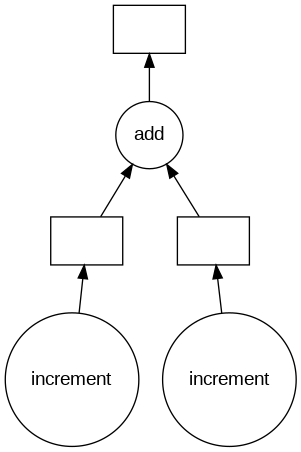

In [14]:
def increment(i):
    return i + 1

def add(x, y):
    return x + y

# функции переноса внутри отложенного объекта и цепочки
x = delayed(increment)(1)
y = delayed(increment)(2)
z = delayed(add)(x, y)

# visualize the DAG
z.visualize()

In [15]:
# show the result
z.compute()

5

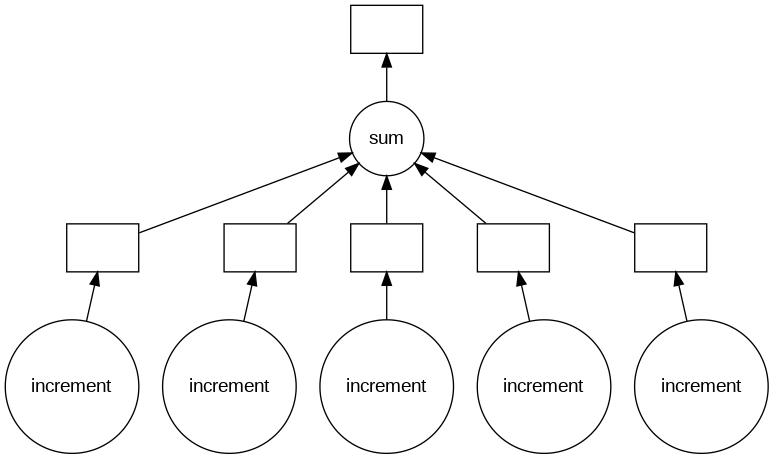

In [16]:
data = [1, 2, 3, 4, 5]

# compile first layer and visualize
layer1 = [delayed(increment)(i) for i in data]
total1 = delayed(sum)(layer1)
total1.visualize()

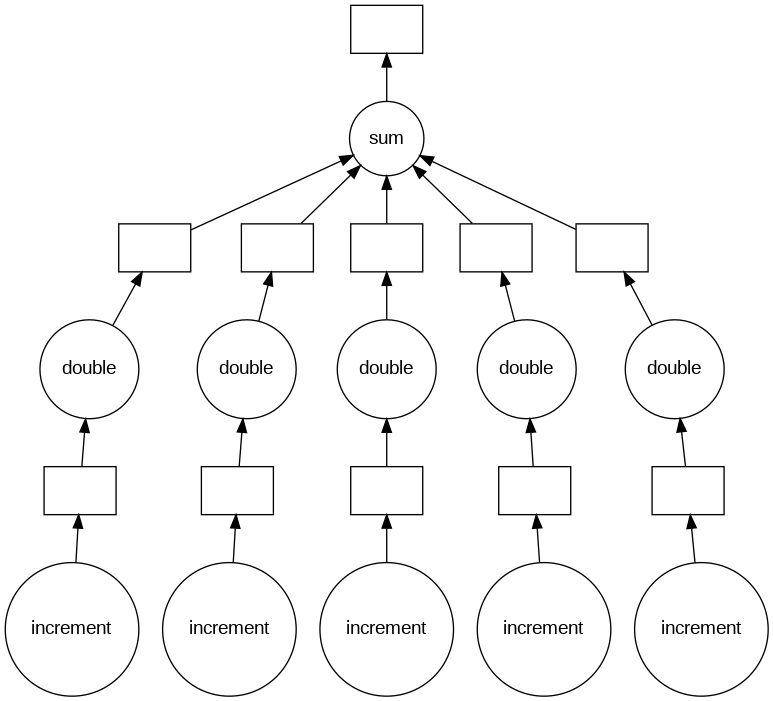

In [17]:
def double(x):
    return x * 2

# compile second layer and visualize
layer2 = [delayed(double)(j) for j in layer1]
total2 = delayed(sum)(layer2)#.persist()
total2.visualize()

In [18]:
z = total2.compute()
z

40

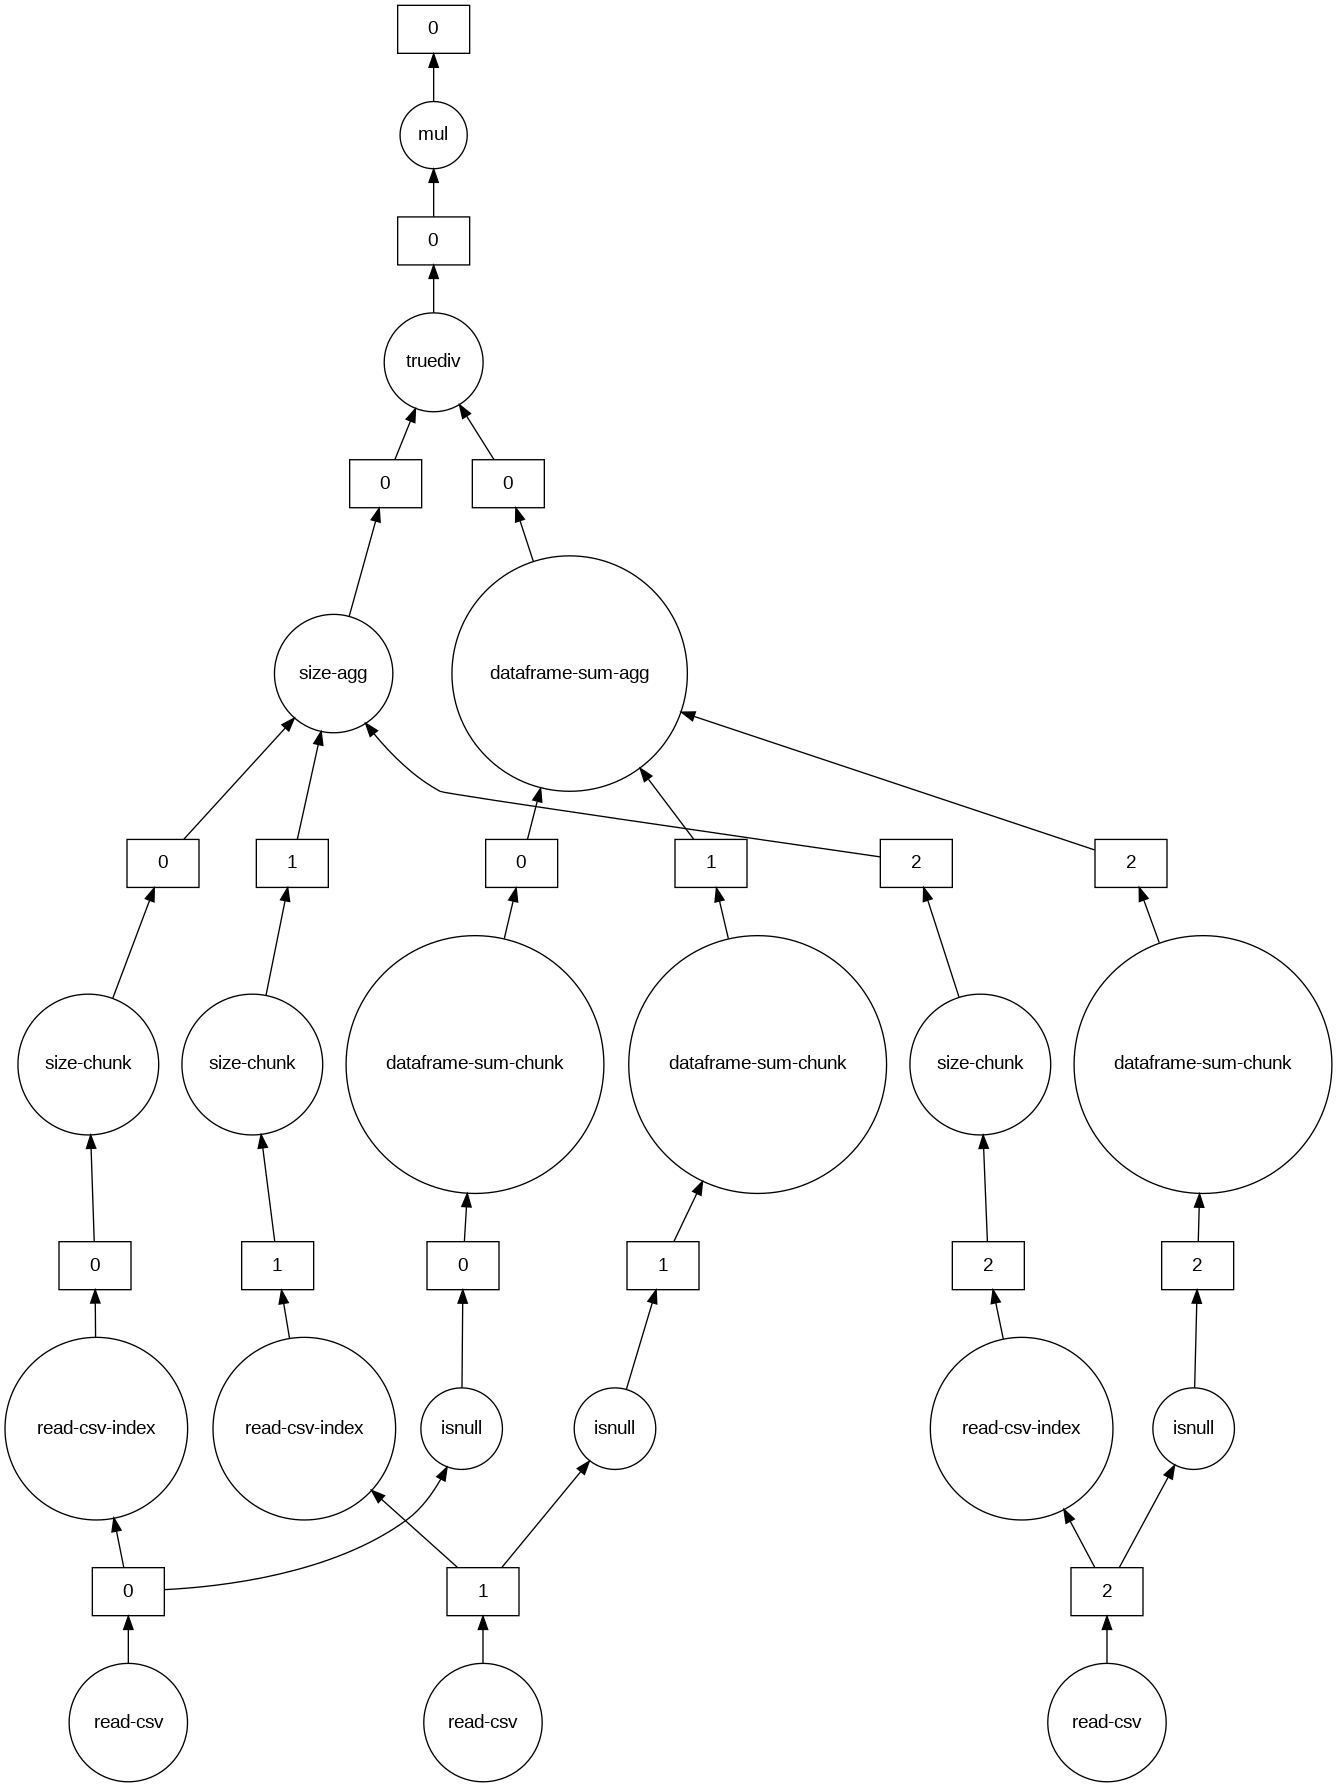

In [19]:
# visualize DAGs built from the DataFrame
missing_count.visualize()